# Assignment 4: Anomaly Detection with VAEs
As we have seen, Variational Autoencoders (VAEs) provide a mathematically grounded framework for the unsupervised learning of latent representations. Besides interpreting VAEs as representation learning or generative modelling, we can also see them as performing (approximate) density approximation. VAEs are trained to optimise a lower bound to the (log) likelihood $\log p(X)$ of the data $X$, under the chosen model. So, for any point in data space, we can obtain an estimate of its likelihood under the trained model, by simply computing the loss function when passing this data point through the neural network (note that the loss function is the negative ELBO, so we need to multiply by -1 to obtain a likelihood estimation).

We can use this idea to perform unsupervised anomaly detection. Suppose we are given a dataset that describes some natural distribution (e.g. images of certain clothing items). For new test data, we then wish to detect whether it fits this distribution, or is significantly different (an anomaly). For example, given a dataset of shirts, we want to detect anomalies in a test data set that also contains some images of trousers. Typically, such a situation occurs when we have many examples of one class (e.g. shirts), but very few of others (the anomalies, e.g. trousers).

In this task, we will perform and evaluate such anomaly detection with VAEs. Given a training data set that consists of instances that we consider "normal", we wish to detect anomalies in a test data set that contains both "normal" (but unseen) examples, as well as other examples which we consider anomalous. The idea is to train a VAE on the training data, such that it learns to represent "normal" data well. We can then compute the ELBO values for the test data, where ideally "normal" examples should obtain higher likelihood values than anomalous examples.

In this assignment, we will use FashionMNIST to simulate the anomaly detection task. We will omit one class from the training data, and consider the remaining 9 classes to be "normal". The goal is then to identify the omitted class in the test data, by comparing the ELBO values obtained from a VAE trained on 9 classes.

**NOTE:**
* **Only fill in the cells marked with `#### INSERT CODE HERE ####` or `<-- WRITE TEXT HERE -->`**
* **Do not add or delete any cells**
* **Make sure to run all cells before handing in.**
* **Re-running all cells in your notebook in order should produce similar output (it may vary slightly due to stochasticity in the training).**
* **You don't need to extensively comment your code, but briefly mention any assumptions you make, or any design choices.**
* **Make sure that the cell output (where needed) is clear and easy to interpret (i.e. print what it is you are outputting, captions/titles for plots).**

## Imports
These should be all the imports you'll need, please don't use any other libraries as this will make it harder to assess your work.

In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks

from sklearn.metrics import roc_curve, precision_recall_curve, auc

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Task 1: Obtain anomaly detection dataset
**(a)** We will consider the "Trouser" class (with label 1) to be the anomalies, and consider the other 9 classes to be our "normal" data. We'll train on normal data only, but we want to test on both normal and anomalous data to evaluate our anomaly detection framework.
* Load the FashionMNIST dataset.
* Remove all instances from the anomaly class from the training set.
* Split the test set in two parts: the anomalous data (with label 1) and the normal data (all other labels).

*Implementation hint: `np.argwhere` may be helpful for splitting the data based on its labels.*

In [2]:
#### INSERT CODE HERE ####
# load dataset and preprocess it
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# remove all istances of the anomaly class from training
anomaly_pos_train = np.argwhere(y_train == 1)
x_train = np.delete(x_train, anomaly_pos_train, axis = 0)
y_train = np.delete(y_train, anomaly_pos_train, axis = 0)

# split test set
anomaly_pos_test = np.argwhere(y_test == 1)
x_test_anomaly = np.squeeze(x_test[anomaly_pos_test], axis = 1)
y_test_anomaly = np.ones(anomaly_pos_test.shape)
x_test = np.delete(x_test, anomaly_pos_test, axis = 0)
y_test = np.delete(y_test, anomaly_pos_test, axis = 0)

**(b)** To check if the split was done correctly, plot some random examples (at least 10 each) of:
* The new training set (without the anomaly class)
* The normal test set
* The anomaly test set

Training set samples...


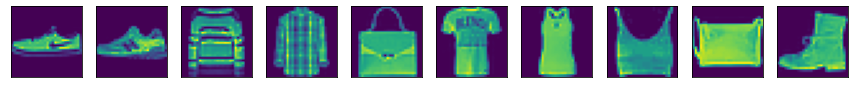

Normal test set samples...


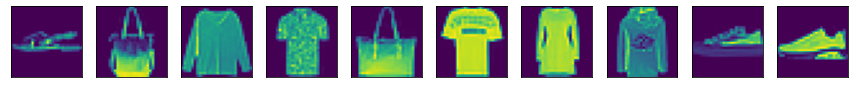

Anomaly test set samples...


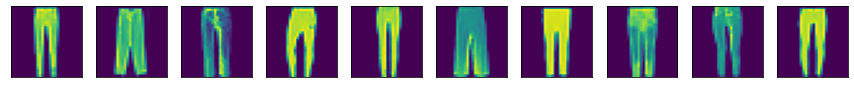

In [3]:
#### INSERT CODE HERE ####
def plot_row_images(
    imgs: np.ndarray,
) -> None:
  """plot images in imgs in a row grid"""
  fig, axes = plt.subplots(1, len(imgs), figsize = (15, 10))
  for i, ax in enumerate(axes):
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(imgs[i])
  plt.show()

# generate random indexes
rand_train = np.random.randint(0, len(x_train), 10)
rand_test = np.random.randint(0, len(x_test), 10)
rand_test_anomaly = np.random.randint(0, len(x_test_anomaly), 10)

# print random images
print('Training set samples...')
plot_row_images(np.squeeze(x_train[rand_train], -1))
print('Normal test set samples...')
plot_row_images(np.squeeze(x_test[rand_test], -1))
print('Anomaly test set samples...')
plot_row_images(np.squeeze(x_test_anomaly[rand_test_anomaly], -1))

## Task 2: Design, implement, and train a VAE
**(a)** Design a VAE for the FashionMNIST dataset with a suitable architecture, that should perform well on this dataset.
* Implement the VAE (with corresponding loss functions) and compile it.
* Print a summary (with `.summary()`) of the encoder and decoder.

*Hint: in Practical 6.1 we used a latent dimension of 2 because it allows for nice latent space plots. This limits the capacity of the VAE however, so here you will want to choose a higher number.*

In [4]:
#### INSERT CODE HERE ####
# parameters 
latent_dim = 50
_, width, height, channels = x_test.shape

# encoder
encoder_in = layers.Input((width, height, channels), name="encoder_in")
h = layers.Conv2D(32, (3, 3), strides=2, activation="relu")(encoder_in)        # (28, 28, 1) -> (13, 13, 32)
h = layers.Conv2D(64, (3, 3), strides=2, activation="relu")(h)                 # (13, 13, 32) -> (6, 6, 64)
h = layers.Flatten()(h)

z_mu = layers.Dense(latent_dim, name='z_mu')(h)               # mu parameter of q(z|x)
z_log_sigma = layers.Dense(latent_dim, name='z_log_sigma')(h) # log sigma parameter of q(z|x)

encoder = Model(inputs=encoder_in, outputs=[z_mu, z_log_sigma], name='Encoder')
encoder.summary()
print('') # go in a new line

# reparametrisation layer
class GaussianSampling(layers.Layer):
    def call(self, inputs):
        z_mu, z_log_sigma = inputs
        epsilon = K.random_normal(K.shape(z_mu))
        return z_mu + K.exp(z_log_sigma) * epsilon

z_sample = GaussianSampling(name="z_sample")([z_mu, z_log_sigma])

# decoder
decoder_in = layers.Input((latent_dim), name='decoder_in')
h = layers.Dense(7 * 7 * 32, activation='relu')(decoder_in)                    # (latent_dim) -> (7 * 7 * 32)
h = layers.Reshape((7, 7, 32))(h)                                              # (7 * 7 * 32) -> (7, 7, 32)
h = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same",              # (7, 7, 32) -> (14, 14, 64)
                           activation="relu")(h)
h = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same",              # (14, 14, 64) -> (28, 28, 32)
                           activation="relu")(h)
output = layers.Conv2DTranspose(1, (3, 3), strides=1, padding="same",          # (28, 28, 32) -> (28, 28, 1)
                                activation="sigmoid")(h)                     

decoder = Model(inputs=decoder_in, outputs=output, name='Decoder')
decoder.summary()
print('') # go in a new line

# VAE
decoded_z = decoder(z_sample)
vae = Model(inputs=encoder.inputs, outputs=decoded_z, name='VAE')
vae.summary()

# compiling vae
x_mean = K.batch_flatten(decoded_z)
x_std = (1 / np.sqrt(2)).astype(np.float32)
x_in = K.batch_flatten(encoder_in)
reconstruction_loss = K.sum(
    K.square(x_in - x_mean) / (2 * x_std ** 2) + K.log(x_std) + 0.5 * K.log(2 * np.pi),
    axis=-1
)
kl_divergence = 0.5 * K.sum(
    K.square(z_mu) + K.exp(2 * z_log_sigma) - 2 * z_log_sigma - 1,
    axis=-1
)
vae.add_loss(reconstruction_loss + kl_divergence)
vae.compile('adam')

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_in (InputLayer)         [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 13, 13, 32)   320         encoder_in[0][0]                 
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 6, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2304)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

**(b)** Train the VAE on the FashionMNIST training dataset without the anomaly class. Make sure that you train long enough such that the loss is no longer going down. Make sure that the training output is printed (use the default `verbose` setting in `.fit`).

In [5]:
#### INSERT CODE HERE ####
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=2)

vae.fit(
    x=x_train,
    epochs=100,
    batch_size=100,
    validation_data=(x_train, None),
    callbacks=[early_stopping]
)

Epoch 1/100
540/540 [==============================] - 5s 9ms/step - loss: 495.2238 - val_loss: 480.5674
Epoch 2/100
540/540 [==============================] - 5s 8ms/step - loss: 478.5743 - val_loss: 477.2365
Epoch 3/100
540/540 [==============================] - 4s 8ms/step - loss: 476.6261 - val_loss: 476.2476
Epoch 4/100
540/540 [==============================] - 5s 8ms/step - loss: 475.8494 - val_loss: 475.6596
Epoch 5/100
540/540 [==============================] - 5s 8ms/step - loss: 475.4325 - val_loss: 475.1501
Epoch 6/100
540/540 [==============================] - 5s 8ms/step - loss: 475.1131 - val_loss: 474.9693
Epoch 7/100
540/540 [==============================] - 5s 8ms/step - loss: 474.8756 - val_loss: 474.8322
Epoch 8/100
540/540 [==============================] - 5s 8ms/step - loss: 474.6678 - val_loss: 474.5380
Epoch 9/100
540/540 [==============================] - 5s 8ms/step - loss: 474.5378 - val_loss: 474.4305
Epoch 10/100
540/540 [==============================] -

## Task 3: Inspect VAE performance
Qualitatively inspect if the VAE isx_trainned well. The latent space plots we saw in the practical only work for 2-dimensional latent spaces, but you may need to increase the dimensionality of the latent space for good performance. Therefore we'll make some plots that work for higher-dimensional latent spaces as well; reconstructions and random samples:

* __Reconstructions:__ Take a random sample of normal training images (at least 10), and use the VAE to obtain their reconstructions. Plot both originals and reconstructions, on top of each other.
* __Random samples:__ Randomly generate some images (at least 10) with the VAE; i.e. sample latent variables from the prior distribution, and decode them into data space. Plot the results.

Plotting reconstructions of random images


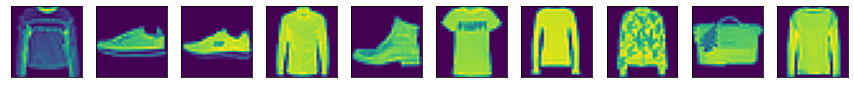

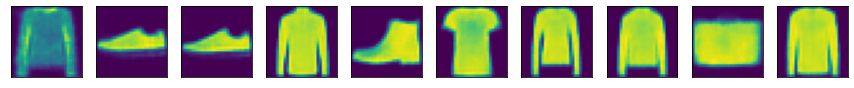

Plotting random samples from latent space


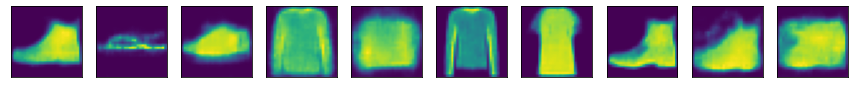

In [6]:
#### INSERT CODE HERE ####
random_training_idx = np.random.randint(0, x_train.shape[0], 10)

print("Plotting reconstructions of random images")
plot_row_images(np.squeeze(x_train[random_training_idx]))
plot_row_images(np.squeeze(vae.predict(x_train[random_training_idx])))

print("Plotting random samples from latent space")
latent_sample = np.random.multivariate_normal(mean=np.zeros((latent_dim,)), cov=np.identity(latent_dim), size=10)
plot_row_images(np.squeeze(decoder.predict(latent_sample)))

## Task 4: Anomaly detection
**(a)** Use the VAE to obtain density/likelihood estimations for the normal and anomalous test sets, i.e. compute the ELBO (the negative of the loss function) for all points in both test sets. Make sure to keep the scores for the normal and anomaly sets separate from each other.

*Implementation hint: Unfortunately, Keras's `.evaluate()` does not allow to access the loss values of individual samples, it only returns the average loss over the entire input. A simple (but slow) workaround is to just use for loops over the entire input and use `.evaluate()` for each data point individually (set `verbose=0` to avoid a long output).*

In [7]:
def likelihood_estimation (
    elems: np.ndarray,
    model: Model,
) -> np.ndarray:
    res = []
    for i, x in enumerate(elems):
        x = np.expand_dims(x, axis=0)
        tmp = model.evaluate(x, verbose=0)
        res.append(-tmp)
    return np.asarray(res)

normal_test_losses = likelihood_estimation(x_test, vae)
anomaly_test_losses = likelihood_estimation(x_test_anomaly, vae)

**(b)** Visualise the scores in a histogram (`plt.hist()`) as well as a density plot (`sns.kdplot` from the `seaborn` library). Use two different colours: **green** for normal data, **red** for anomalous data, and show both normal and anomalous scores in the same plot (use transparency to make visualisation clearer), i.e. one figure with both histograms, and one figure with both density plots.

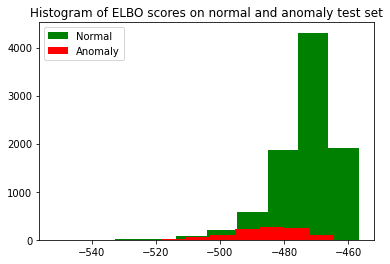

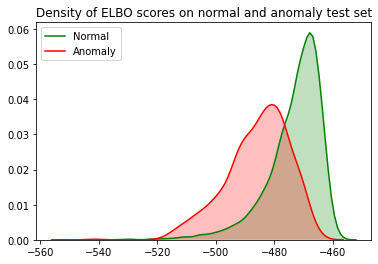

In [8]:
#### INSERT CODE HERE ####
plt.hist(normal_test_losses, label="Normal", color="green")
plt.hist(anomaly_test_losses, label="Anomaly", color="red")
plt.legend()
plt.title("Histogram of ELBO scores on normal and anomaly test set")
plt.show()

sns.kdeplot(normal_test_losses, shade=True, label="Normal", color="green")
sns.kdeplot(anomaly_test_losses, shade=True, label="Anomaly", color="red")
plt.title("Density of ELBO scores on normal and anomaly test set")
plt.show()

**(c)** Given these likelihood scores, we can choose a threshold and classify all instances with a likelihood below the threshold as anomalies, and all instances with a likelihood above the threshold as "normal". Different thresholds will give different True/False Positive/Negative scores. We can summarise the performance of all thresholds in an ROC curve, or a Precision-Recall curve (the latter has been shown to be more suitable for imbalanced datasets, see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/).
* Plot an ROC curve for your results, compute and show the Area Under Curve (AUC) score for quantitative evaluation.
* Plot a Precision-Recall curve for your results, compute and show the Area Under Curve (AUC) score for quantitative evaluation.

*Implementation hints:*
* *See https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/ for more information about ROC and PR curves and their implementation with `sklearn`.*
* *ROC/PR curves are typically used for binary classification. You can define anomaly as label 0 and normal as 1, and rescale the ELBO scores from part (a) to be between 0 and 1 (by using the minimum and maximum values in your ELBO results) to express them as binary classification probabilities.*

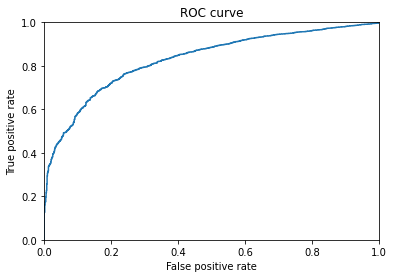

Area under ROC: 0.8299691666666666


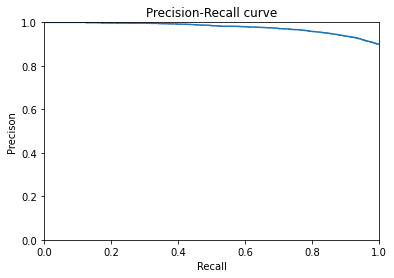

Area under Precision-Recall curve: 0.9772704843151684


In [9]:
#### INSERT CODE HERE ####
losses_min = min(normal_test_losses.min(), anomaly_test_losses.min())
losses_max = max(normal_test_losses.max(), anomaly_test_losses.max())
scaled_normal_losses = (normal_test_losses - losses_min) / (losses_max - losses_min)
scaled_anomaly_losses = (anomaly_test_losses - losses_min) / (losses_max - losses_min)

y_true = np.concatenate((np.ones_like(normal_test_losses), np.zeros_like(anomaly_test_losses)))
y_pred = np.concatenate((scaled_normal_losses, scaled_anomaly_losses))

fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, scalex=False, scaley=False)
plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

auroc = auc(fpr, tpr)
print(f"Area under ROC: {auroc}")

precision, recall, thresholds_prc = precision_recall_curve(y_true, y_pred)
plt.plot(recall, precision, scalex=False, scaley=False)
plt.title("Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precison")
plt.show()

auprc = auc(recall, precision)
print(f"Area under Precision-Recall curve: {auprc}")

**(d)** Ideally, a successful VAE for anomaly detection should represent (and thus reconstruct) normal data very well, but not anomalous data. Reconstruct some random images (at least 10 each) from the normal test set, as well as from the anomaly test set. Show the original images and their reconstructions on top of each other.

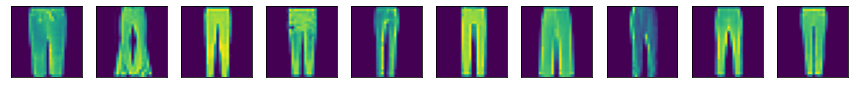

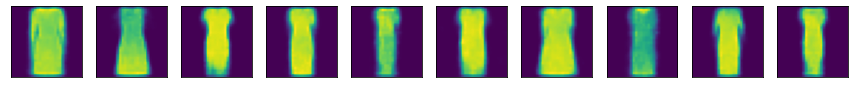

In [10]:
#### INSERT CODE HERE ####
plot_row_images(np.squeeze(x_test_anomaly[24:34]))
plot_row_images(np.squeeze(vae.predict(x_test_anomaly[24:34])))

**(e)** Give a detailed discussion of your results; does the anomaly detection perform well? Why do you think so? What could be improved? Discuss each of the results from parts (b), (c), and (d) separately.

<-- WRITE TEXT HERE -->

## Task 5: Peer review
Finally, each group member must write a single paragraph outlining their opinion on the work distribution within the group. Did every group member contribute equally? Did you split up tasks in a fair manner, or jointly work through the exercises? Do you think that some members of your group deserve a different grade from others?

<-- WRITE TEXT HERE -->